In [2]:
import pandas as pd
import numpy as np
import random 
import torch 
import os 
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch import nn
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import image
import shutil

In [3]:
from models import * 
from predict import * 
from dataloader import * 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
chexpert_dir = '/scratch/paa9751/mlhc-project/resized_data/chexpert'
mimic_dir = '/scratch/paa9751/mlhc-project/resized_data/mimic'
M_LABEL = 'negbio'
IMAGE_SIZE = 256
NORMALISE = False
NWORKERS = 6 
BATCH_SIZE = 16 
BORDER_SZ = 25
K = 10000
TRANSFORM=True
USE_SNS=False

torch.manual_seed(42)

train_dataloader, val_dataloader, test_dataloader = load_resized_data(chexpert_dir, mimic_dir, IMAGE_SIZE, NORMALISE, TRANSFORM, NWORKERS, BATCH_SIZE, BORDER_SZ, USE_SNS)

#### check dataloaders: 

In [4]:
test_l = []
test_batch_y = []
for batch_x, batch_y, l in test_dataloader: 
    test_l.append(np.array(list(l)))
    test_batch_y.append(batch_y.detach().numpy())
test_l = np.concatenate( test_l, axis=0 ).tolist()
test_batch_y = np.concatenate( test_batch_y, axis=0 ).tolist()
df = pd.DataFrame({'l': test_l, 'y':test_batch_y})

In [6]:
for batch_x, batch_y, l in train_dataloader: 
    print(l)
    break

tensor([0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2])


In [5]:
df.l.value_counts()

l
3    1350
1    1350
0     150
2     150
Name: count, dtype: int64

In [10]:
val_l = []
val_batch_y = []
for batch_x, batch_y, l in val_dataloader: 
    val_l.append(np.array(list(l)))
    val_batch_y.append(batch_y.detach().numpy())
val_l = np.concatenate(val_l, axis=0 ).tolist()
val_batch_y = np.concatenate(val_batch_y, axis=0 ).tolist()
df = pd.DataFrame({'l': val_l, 'y':val_batch_y})

### get p(y|z)

In [4]:
model_path = 'out/epoch_200+weightdecay_0.001+model_resnet18+pretrained_False+batchsize_16+lr_0.0001_final_model.pth'
df_pred = get_train_pred_df(model_path, BORDER_SZ, device)

0.0% pred done
0.7142857142857143% pred done
1.4285714285714286% pred done
2.142857142857143% pred done
2.857142857142857% pred done
3.5714285714285716% pred done
4.285714285714286% pred done
5.0% pred done
5.714285714285714% pred done
6.428571428571429% pred done
7.142857142857143% pred done
7.857142857142857% pred done
8.571428571428571% pred done
9.285714285714286% pred done
10.0% pred done
10.714285714285714% pred done
11.428571428571429% pred done
12.142857142857142% pred done
12.857142857142858% pred done
13.571428571428571% pred done
14.285714285714286% pred done
15.0% pred done
15.714285714285714% pred done
16.428571428571427% pred done
17.142857142857142% pred done
17.857142857142858% pred done
18.571428571428573% pred done
19.285714285714285% pred done
20.0% pred done
20.714285714285715% pred done
21.428571428571427% pred done
22.142857142857142% pred done
22.857142857142858% pred done
23.571428571428573% pred done
24.285714285714285% pred done
25.0% pred done
25.714285714285

### plot p(y|z)

In [24]:
df_pred_combined = pd.read_csv('resized_data/train_combined_df_epoch100.csv')

In [25]:
groups_mapping={'chexpert_1':0, 'chexpert_0':1, 'mimic_0':2, 'mimic_1':3}

In [26]:
df_pred_combined

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx,true_group,true_group_idx,predicted_prob
0,patient32083,1.0,CheXpert-v1.0/train/patient32083/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999999
1,patient56899,1.0,CheXpert-v1.0/train/patient56899/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999757
2,patient17799,1.0,CheXpert-v1.0/train/patient17799/study2/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999902
3,patient34816,1.0,CheXpert-v1.0/train/patient34816/study6/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999685
4,patient36940,1.0,CheXpert-v1.0/train/patient36940/study2/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.984407
...,...,...,...,...,...,...,...,...,...
13995,15951517,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p15/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.025442
13996,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.023468
13997,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.018780
13998,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.312123


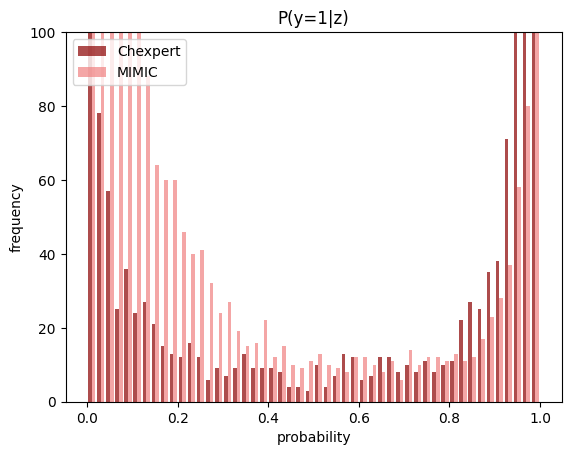

In [45]:
plt.title('P(y=1|z)')
chex = df_pred_combined[df_pred_combined.dataset_idx==1]['predicted_prob']
mim = df_pred_combined[df_pred_combined.dataset_idx==0]['predicted_prob']
#plt.hist(df_pred_combined.predicted_prob.tolist(),bins=10, color='darkred')
plt.hist([chex, mim], bins=50, color=['darkred', 'lightcoral'], alpha=0.7,label=['Chexpert', 'MIMIC'])
plt.xlabel('probability')
plt.ylabel('frequency')
plt.ylim(top=100)
plt.legend(loc='upper left')

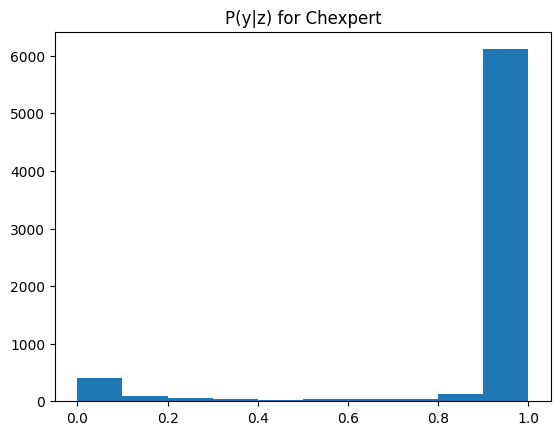

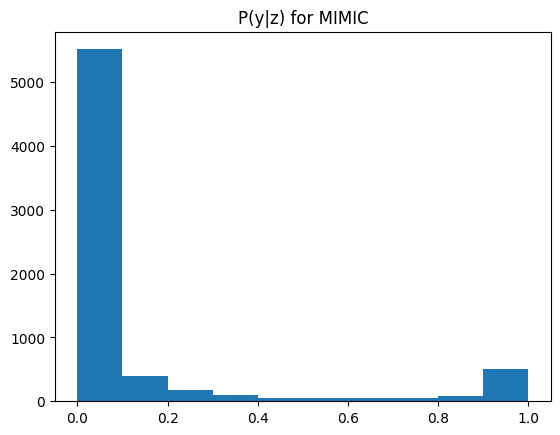

In [178]:
plt.title('P(y|z) for Chexpert')
plt.hist(df_pred_combined[df_pred_combined.dataset_idx==1].predicted_prob.tolist())
plt.show()
plt.title('P(y|z) for MIMIC')
plt.hist(df_pred_combined[df_pred_combined.dataset_idx==0].predicted_prob.tolist())
plt.show()

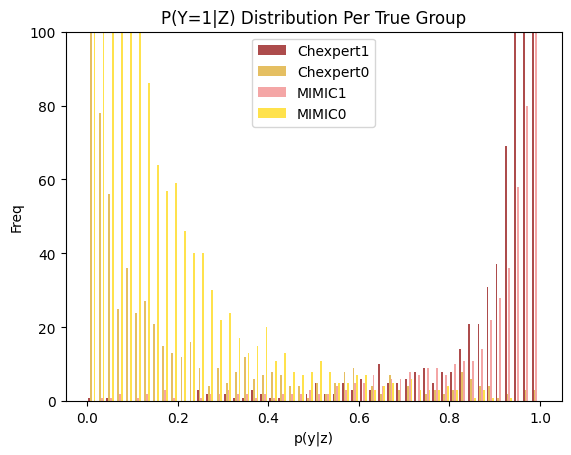

In [55]:
# Separate values based on the group
chexpert1 = df_pred_combined[df_pred_combined.true_group_idx==groups_mapping['chexpert_1']]['predicted_prob']
chexpert0 = df_pred_combined[df_pred_combined.true_group_idx==groups_mapping['chexpert_0']]['predicted_prob']
mimic1 = df_pred_combined[df_pred_combined.true_group_idx==groups_mapping['mimic_1']]['predicted_prob']
mimic0 = df_pred_combined[df_pred_combined.true_group_idx==groups_mapping['mimic_0']]['predicted_prob']


# Plot histogram with different colors for each group
plt.hist([chexpert1, chexpert0, mimic1, mimic0], bins=50, color=['darkred', 'goldenrod', 'lightcoral', 'gold'], alpha=0.7, 
         label=['Chexpert1', 'Chexpert0', 'MIMIC1', 'MIMIC0'])

# Add labels and legend
plt.xlabel('p(y|z)')
plt.ylabel('Freq')
plt.ylim(top=100)
plt.title('P(Y=1|Z) Distribution Per True Group')
plt.legend()

In [180]:
df_pred_combined=df_pred_combined.sample(frac=1)

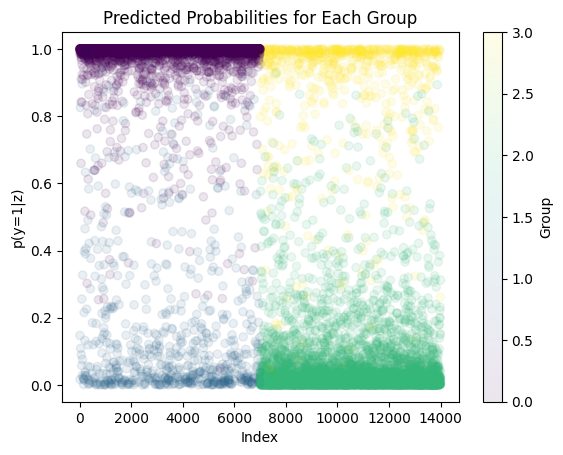

In [181]:
plt.scatter(df_pred_combined.index, df_pred_combined['predicted_prob'], c=df_pred_combined['true_group_idx'], cmap='viridis', alpha=0.1)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('p(y=1|z)')
plt.title('Predicted Probabilities for Each Group')

# Add a colorbar for group differentiation
cbar = plt.colorbar()
cbar.set_label('Group')

# Show the plot
plt.show()

In [50]:
thresh=0.5
df_pred_combined['sns_group'] = [0 if p<thresh else 1 for p in df_pred_combined.predicted_prob]
df_pred_combined

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx,true_group,true_group_idx,predicted_prob,sns_group
0,patient32083,1.0,CheXpert-v1.0/train/patient32083/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999999,1
1,patient56899,1.0,CheXpert-v1.0/train/patient56899/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999757,1
2,patient17799,1.0,CheXpert-v1.0/train/patient17799/study2/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999902,1
3,patient34816,1.0,CheXpert-v1.0/train/patient34816/study6/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.999685,1
4,patient36940,1.0,CheXpert-v1.0/train/patient36940/study2/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.984407,1
...,...,...,...,...,...,...,...,...,...,...
13995,15951517,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p15/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.025442,0
13996,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.023468,0
13997,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.018780,0
13998,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.312123,0


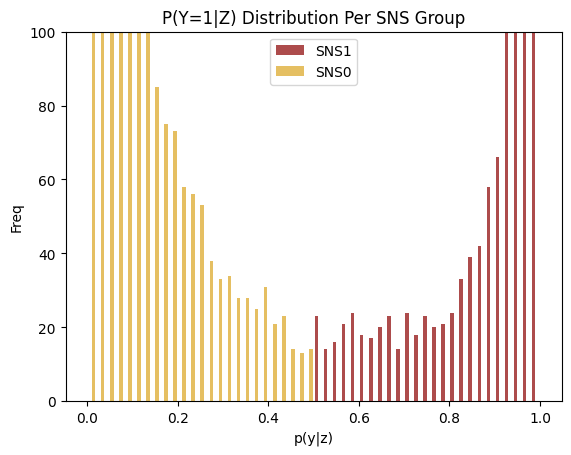

In [57]:
# Separate values based on the group
sns1 = df_pred_combined[df_pred_combined.sns_group==1]['predicted_prob'].tolist()
sns0 = df_pred_combined[df_pred_combined.sns_group==0]['predicted_prob'].tolist()


# Plot histogram with different colors for each group
plt.hist([sns1, sns0], bins=50, color=['darkred', 'goldenrod'], alpha=0.7,label=['SNS1', 'SNS0'])

# Add labels and legend
plt.xlabel('p(y|z)')
plt.ylabel('Freq')
plt.ylim(top=100)
plt.title('P(Y=1|Z) Distribution Per SNS Group')
plt.legend()

#### Append SNS Groups to DF

In [185]:
chexpert = pd.read_csv('resized_data/chexpert/full_data_chexpert.csv')
mimic = pd.read_csv('resized_data/mimic/full_data_mimic.csv')

In [190]:
combined = pd.concat([chexpert, mimic])

In [188]:
df_pred_combined = df_pred_combined.reset_index()

In [191]:
combined

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx,true_group,true_group_idx
0,patient32083,1.0,CheXpert-v1.0/train/patient32083/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
1,patient56899,1.0,CheXpert-v1.0/train/patient56899/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
2,patient17799,1.0,CheXpert-v1.0/train/patient17799/study2/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
3,patient34816,1.0,CheXpert-v1.0/train/patient34816/study6/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
4,patient36940,1.0,CheXpert-v1.0/train/patient36940/study2/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
...,...,...,...,...,...,...,...,...
9995,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2
9996,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2
9997,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2
9998,19412899,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2


In [189]:
df_pred_combined

,index,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx,true_group,true_group_idx,predicted_prob,sns_group
0,12966,10979375,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.104649,0
1,12161,19524641,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.090485,0
2,9044,15952397,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p15/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.222327,0
3,11213,12027769,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p12/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.043290,0
4,7930,19259547,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.063865,0
...,...,...,...,...,...,...,...,...,...,...,...
13995,7582,13010793,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p13/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.003370,0
13996,11735,13831349,1.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p13/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,10,3,0.987040,1
13997,12189,12421959,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p12/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.020953,0
13998,6778,patient21622,1.0,CheXpert-v1.0/train/patient21622/study18/view1...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0,0.996220,1


In [198]:
combined_preds = pd.merge(combined, df_pred_combined[['new_path', 'predicted_prob','sns_group']], on='new_path', how='outer')

In [202]:
combined_preds.sns_group.value_counts()

sns_group
1.0    7117
0.0    6883
Name: count, dtype: int64

In [206]:
combined_preds[combined_preds.dataset_idx==0]

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx,true_group,true_group_idx,predicted_prob,sns_group
10000,19091570,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.035207,0.0
10001,14882082,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p14/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.109568,0.0
10002,10641937,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.001892,0.0
10003,19496864,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.012833,0.0
10004,16316457,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.011912,0.0
...,...,...,...,...,...,...,...,...,...,...
19995,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.023468,0.0
19996,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.018780,0.0
19997,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.312123,0.0
19998,19412899,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,0,2,0.001617,0.0


In [207]:
combined_preds[combined_preds.dataset_idx==1].to_csv('resized_data/chexpert/full_data_chexpert.csv', index=False)
combined_preds[combined_preds.dataset_idx==0].to_csv('resized_data/mimic/full_data_mimic.csv', index=False)

### Plot Loss/Accuracy Curves During Training

#### 1. Robust Training - True:

In [22]:
robust_training_loss = np.load('out-robust/epoch_200+weightdecay_0.0001+model_resnet18+pretrained_False+batchsize_128+lr_0.001_r_training_losses.npy')
train_accuracy = np.load('out-robust/epoch_200+weightdecay_0.0001+model_resnet18+pretrained_False+batchsize_128+lr_0.001_training_accuracy.npy')
val_accuracy = np.load('out-robust/epoch_200+weightdecay_0.0001+model_resnet18+pretrained_False+batchsize_128+lr_0.001_validation_accuracy.npy')
val_loss = np.load('out-robust/epoch_200+weightdecay_0.0001+model_resnet18+pretrained_False+batchsize_128+lr_0.001_validation_losses.npy')
avg_training_loss = np.load('out-robust/epoch_200+weightdecay_0.0001+model_resnet18+pretrained_False+batchsize_128+lr_0.001_training_losses.npy')


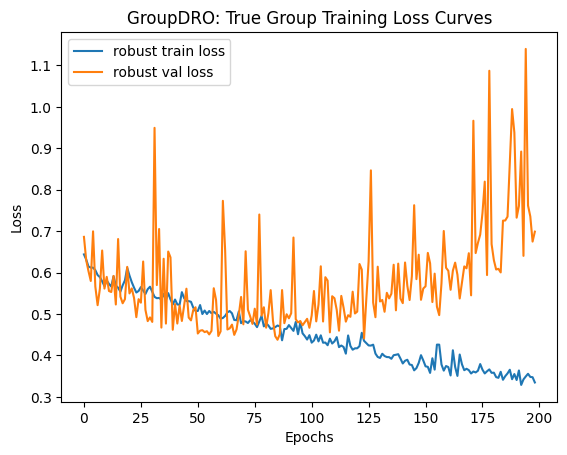

In [6]:
plt.title('GroupDRO: True Group Training Loss Curves')
plt.plot(robust_training_loss[1:], label="robust train loss")
plt.plot(val_loss[1:], label="robust val loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

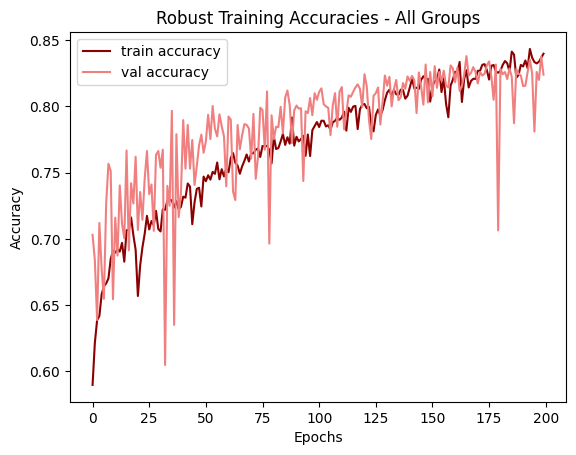

In [23]:
plt.title('Robust Training Accuracies - All Groups')
plt.plot(train_accuracy, label="train accuracy", color='darkred')
plt.plot(val_accuracy, label="val accuracy", color='lightcoral')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

##

#### 2. Nuisance Training 

In [10]:
train_accuracy = np.load('out/epoch_200+weightdecay_0.001+model_resnet18+pretrained_False+batchsize_128+lr_0.0001_training_accuracy.npy')
val_accuracy = np.load('out/epoch_200+weightdecay_0.001+model_resnet18+pretrained_False+batchsize_128+lr_0.0001_validation_accuracy.npy')
val_loss = np.load('out/epoch_200+weightdecay_0.001+model_resnet18+pretrained_False+batchsize_128+lr_0.0001_validation_losses.npy')
training_loss = np.load('out/epoch_200+weightdecay_0.001+model_resnet18+pretrained_False+batchsize_128+lr_0.0001_training_losses.npy')

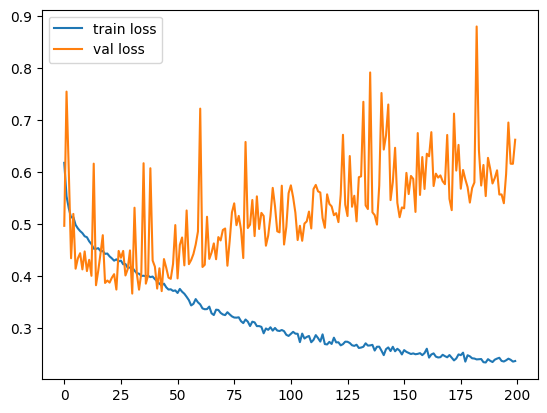

In [11]:
plt.plot(training_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.legend()

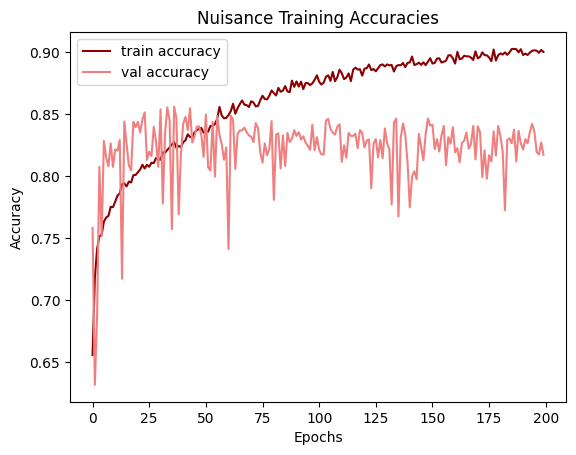

In [20]:
plt.title('Nuisance Training Accuracies')
plt.plot(train_accuracy, label="train accuracy", color='darkred')
plt.plot(val_accuracy, label="val accuracy", color='lightcoral')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [96]:
chexpert_data = pd.read_csv('resized_data/chexpert/full_data_chexpert.csv')
mimic_data = pd.read_csv('resized_data/mimic/full_data_mimic.csv')

In [97]:
combined = pd.concat([chexpert_data, mimic_data])

In [98]:
combined.true_group_idx.value_counts()

true_group_idx
0    7800
2    7800
1    2200
3    2200
Name: count, dtype: int64

In [19]:
print('train, chexpert target split:')
print(combined[(combined.split=='train')&(combined.dataset_idx==1)].Cardiomegaly.value_counts())
print('train, mimic target split:')
print(combined[(combined.split=='train')&(combined.dataset_idx==0)].Cardiomegaly.value_counts())
print('val, chexpert target split:')
print(combined[(combined.split=='val')&(combined.dataset_idx==1)].Cardiomegaly.value_counts())
print('val, mimic target split:')
print(combined[(combined.split=='val')&(combined.dataset_idx==0)].Cardiomegaly.value_counts())
print('test, chexpert target split:')
print(combined[(combined.split=='test')&(combined.dataset_idx==1)].Cardiomegaly.value_counts())
print('test, mimic target split:')
print(combined[(combined.split=='test')&(combined.dataset_idx==0)].Cardiomegaly.value_counts())

train, chexpert target split:
Cardiomegaly
1.0    6300
0.0     700
Name: count, dtype: int64
train, mimic target split:
Cardiomegaly
0.0    6300
1.0     700
Name: count, dtype: int64
val, chexpert target split:
Cardiomegaly
1.0    1350
0.0     150
Name: count, dtype: int64
val, mimic target split:
Cardiomegaly
0.0    1350
1.0     150
Name: count, dtype: int64
test, chexpert target split:
Cardiomegaly
0.0    1350
1.0     150
Name: count, dtype: int64
test, mimic target split:
Cardiomegaly
1.0    1350
0.0     150
Name: count, dtype: int64


In [23]:
from create_resized_images import * 

In [20]:
chexpert_dir = '/scratch/kj1447/MLHC/chexpert/chexpertchestxrays-u20210408'
mimic_dir = '/scratch/paa9751/mlhc-project'
label_type = 'negbio' #this can be negbio or chexpert 
mimic_info = (mimic_dir, label_type)

In [21]:
chex_imgs = os.listdir('resized_data/chexpert/imgs')
mimic_imgs = os.listdir('resized_data/mimic/imgs')

In [59]:
chexpert_df = pd.read_csv(os.path.join(chexpert_dir, 'CheXpert-v1.0/train.csv')) 
chexpert_df['subject_id'] = chexpert_df.Path.str.split('/').str[2]

In [61]:
chexpert_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,subject_id
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,patient00001
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,patient00002
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,patient00002
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient00003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0/train/patient64537/study2/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,patient64537
223410,CheXpert-v1.0/train/patient64537/study1/view1_...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,patient64537
223411,CheXpert-v1.0/train/patient64538/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,patient64538
223412,CheXpert-v1.0/train/patient64539/study1/view1_...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0,patient64539


In [62]:
resized_paths=[]
for p in chexpert_df.Path:
    resized_paths.append("".join(p.split('/'))[:-4]+".npy")
    
chexpert_df['resized_paths'] = resized_paths

chexpert_df_r = chexpert_df[chexpert_df.resized_paths.isin(chex_imgs)]

In [63]:
#train: 
df1=chexpert_df_r[chexpert_df_r.Cardiomegaly==1.0]
df0=chexpert_df_r[chexpert_df_r.Cardiomegaly==0]
df_train = pd.concat([df1.sample(n=6300, random_state=42), df0.sample(n=700, random_state=42)])
df_train['split'] = 'train'
train_paths = df_train.resized_paths.tolist()

In [64]:
#val: does not incl train
nottrain = chexpert_df_r[~chexpert_df_r.resized_paths.isin(train_paths)]
df1=nottrain[(nottrain.Cardiomegaly==1.0)]
df0=nottrain[(nottrain.Cardiomegaly==0)]
df_val = pd.concat([df1.sample(n=1350, random_state=42), df0.sample(n=150, random_state=42)])
df_val['split'] = 'val'

In [65]:
#test: take whats left 
val_paths = df_val.resized_paths.tolist()
train_val_paths = train_paths + val_paths
df_test = chexpert_df_r[~chexpert_df_r.resized_paths.isin(train_val_paths)]
df_test['split'] = 'test'

/state/partition1/job-40886834/ipykernel_2968721/528361361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['split'] = 'test'


In [66]:
chexpert = pd.concat([df_train, df_val, df_test]).sample(frac=1, random_state=42).reset_index(drop=True)

In [67]:
keep_cols = ['subject_id', 'Cardiomegaly', 'old_path', 'new_path', 'split', 'dataset_idx']

In [68]:
chexpert['new_path'] = '/scratch/paa9751/mlhc-project/resized_data/chexpert/imgs/'+ chexpert.resized_paths.map(str)

In [69]:
chexpert['dataset_idx']=1
chexpert=chexpert.rename(columns={'Path':'old_path'})

In [70]:
chexpert_full_data = chexpert[keep_cols]

In [71]:
chexpert_full_data

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx
0,patient32083,1.0,CheXpert-v1.0/train/patient32083/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
1,patient56899,1.0,CheXpert-v1.0/train/patient56899/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
2,patient17799,1.0,CheXpert-v1.0/train/patient17799/study2/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
3,patient34816,1.0,CheXpert-v1.0/train/patient34816/study6/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
4,patient36940,1.0,CheXpert-v1.0/train/patient36940/study2/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
...,...,...,...,...,...,...
9995,patient41815,1.0,CheXpert-v1.0/train/patient41815/study4/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
9996,patient35481,1.0,CheXpert-v1.0/train/patient35481/study3/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
9997,patient08002,1.0,CheXpert-v1.0/train/patient08002/study4/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
9998,patient16735,1.0,CheXpert-v1.0/train/patient16735/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1


#### remake mimic: 

In [72]:
mimic_imgs[:5]

['mimic-cxr-jpg-2.0.0.physionet.orgfilesp14p14183192s54067646aaa046e2-cb1ba8cc-b29fa201-b2627490-5bf26bef.npy',
 'mimic-cxr-jpg-2.0.0.physionet.orgfilesp16p16519000s505125136fdc3e18-60148c6b-51f7cfba-670a5ab8-00a28e05.npy',
 'mimic-cxr-jpg-2.0.0.physionet.orgfilesp19p19966115s591645936702e8d8-bce3e905-b40b704b-328e2509-519d4817.npy',
 'mimic-cxr-jpg-2.0.0.physionet.orgfilesp13p13774492s55564259b66d58d7-9b9b4dfd-4ef83428-7c4f8a72-2be2a158.npy',
 'mimic-cxr-jpg-2.0.0.physionet.orgfilesp15p15896535s55627097dbf4b6ed-bccbc57f-b0161031-56673c7d-9f49d00a.npy']

In [73]:
mimic_df = pd.read_csv(os.path.join(mimic_info[0], f'mimic-cxr-jpg-2.0.0.physionet.org/paths-incl-mimic-cxr-2.0.0-{mimic_info[1]}.csv'))    

In [74]:
resized_paths=[]
for p in mimic_df.full_path:
    resized_paths.append("".join(p.split('/'))[:-4]+".npy")
    
mimic_df['resized_paths'] = resized_paths
mimic_df_r = mimic_df[mimic_df.resized_paths.isin(mimic_imgs)]

In [75]:
m_df1=mimic_df_r[mimic_df_r.Cardiomegaly==1.0]
m_df0=mimic_df_r[mimic_df_r.Cardiomegaly==0]
df_train = pd.concat([m_df1.sample(n=700, random_state=42), m_df0.sample(n=6300, random_state=42)])
df_train['split'] = 'train'
train_paths = df_train.resized_paths.tolist()

In [76]:
nottrain = mimic_df_r[~mimic_df_r.resized_paths.isin(train_paths)]
m_df1=nottrain[(nottrain.Cardiomegaly==1.0)]
m_df0=nottrain[(nottrain.Cardiomegaly==0)]
df_val = pd.concat([m_df1.sample(n=150, random_state=42), m_df0.sample(n=1350, random_state=42)])
df_val['split'] = 'val'
val_paths = df_val.resized_paths.tolist()

In [79]:
df_test = mimic_df_r[~mimic_df_r.resized_paths.isin(train_paths+val_paths)]
df_test['split'] = 'test'

/state/partition1/job-40886834/ipykernel_2968721/2708299704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['split'] = 'test'


In [83]:
mimic = pd.concat([df_train, df_val, df_test]).sample(frac=1, random_state=42).reset_index(drop=True)

In [84]:
keep_cols = ['subject_id', 'Cardiomegaly', 'old_path', 'new_path', 'split', 'dataset_idx']

In [85]:
mimic['new_path'] = '/scratch/paa9751/mlhc-project/resized_data/mimic/imgs/'+ mimic.resized_paths.map(str)

In [86]:
mimic['dataset_idx']=0
mimic=mimic.rename(columns={'full_path':'old_path'})

In [87]:
mimic_full_data = mimic[keep_cols]

In [88]:
mimic_full_data

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx
0,19091570,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
1,14882082,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p14/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
2,10641937,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p10/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
3,19496864,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
4,16316457,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
...,...,...,...,...,...,...
9995,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
9996,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
9997,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
9998,19412899,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0


In [89]:
combined = pd.concat([chexpert_full_data,mimic_full_data])
combined

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx
0,patient32083,1.0,CheXpert-v1.0/train/patient32083/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
1,patient56899,1.0,CheXpert-v1.0/train/patient56899/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
2,patient17799,1.0,CheXpert-v1.0/train/patient17799/study2/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
3,patient34816,1.0,CheXpert-v1.0/train/patient34816/study6/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
4,patient36940,1.0,CheXpert-v1.0/train/patient36940/study2/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1
...,...,...,...,...,...,...
9995,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
9996,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
9997,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0
9998,19412899,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0


In [90]:
combined['true_group']=combined.Cardiomegaly.astype(int).astype(str) + combined.dataset_idx.astype(str)

In [91]:
combined['true_group_idx']=pd.factorize(combined.true_group)[0]

In [92]:
combined.true_group.value_counts()

true_group
11    7800
00    7800
01    2200
10    2200
Name: count, dtype: int64

In [93]:
combined

,subject_id,Cardiomegaly,old_path,new_path,split,dataset_idx,true_group,true_group_idx
0,patient32083,1.0,CheXpert-v1.0/train/patient32083/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
1,patient56899,1.0,CheXpert-v1.0/train/patient56899/study1/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
2,patient17799,1.0,CheXpert-v1.0/train/patient17799/study2/view2_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
3,patient34816,1.0,CheXpert-v1.0/train/patient34816/study6/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
4,patient36940,1.0,CheXpert-v1.0/train/patient36940/study2/view1_...,/scratch/paa9751/mlhc-project/resized_data/che...,train,1,11,0
...,...,...,...,...,...,...,...,...
9995,16334516,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p16/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,00,2
9996,11054726,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p11/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,00,2
9997,17967970,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p17/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,00,2
9998,19412899,0.0,mimic-cxr-jpg-2.0.0.physionet.org/files/p19/p1...,/scratch/paa9751/mlhc-project/resized_data/mim...,train,0,00,2


In [94]:
combined[combined.dataset_idx==1].to_csv('resized_data/chexpert/full_data_chexpert.csv', index=False)

In [95]:
combined[combined.dataset_idx==0].to_csv('resized_data/mimic/full_data_mimic.csv', index=False)